# Financial Analysis

**Objective:** Comprehensive financial analysis including revenue trends, unit economics by segment, P&L proxy, and scenario planning projections.

**Date Created:** 19/12/2025

**Author:** André Bomfim

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

## 2. Configuration

In [3]:
PROJECT_ID = 'quintoandar-ecommerce-analysis'
KEY_PATH = "C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json"

credentials = service_account.Credentials.from_service_account_file(KEY_PATH)
client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

figures_dir = 'presentation/figures/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

exports_dir = 'exports/'
if not os.path.exists(exports_dir):
    os.makedirs(exports_dir)

print("Configuration successful")
print(f"Project ID: {PROJECT_ID}")
print(f"Credentials loaded: {KEY_PATH}")
print(f"Figures directory: {figures_dir}")
print(f"Exports directory: {exports_dir}")
print("BigQuery client ready.")

Configuration successful!
Project ID: quintoandar-ecommerce-analysis
Credentials loaded: C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json
Figures directory: presentation/figures/
Exports directory: exports/
BigQuery client ready.


## 3. SQL Queries & Data Loading

In [4]:
query_revenue = """
SELECT * 
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_revenue_summary`
WHERE time_period = 'monthly'
ORDER BY revenue_date
"""

query_unit_economics = """
SELECT * 
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_unit_economics`
"""

query_aov = """
SELECT * 
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_aov_analysis`
"""

query_geographic = """
SELECT * 
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_geographic_performance`
"""

df_revenue = client.query(query_revenue).to_dataframe()
df_unit_economics = client.query(query_unit_economics).to_dataframe()
df_aov = client.query(query_aov).to_dataframe()
df_geographic = client.query(query_geographic).to_dataframe()

print(f"Revenue data loaded: {len(df_revenue)} rows")
print(f"Unit economics data loaded: {len(df_unit_economics)} rows")
print(f"AOV data loaded: {len(df_aov)} rows")
print(f"Geographic data loaded: {len(df_geographic)} rows")

Revenue data loaded: 22 rows
Unit economics data loaded: 53 rows
AOV data loaded: 95417 rows
Geographic data loaded: 27 rows


## 4. Data Validation

In [5]:
df_revenue['revenue_date'] = pd.to_datetime(df_revenue['revenue_date'])
df_revenue = df_revenue[df_revenue['total_revenue'] > 0]
df_revenue = df_revenue.sort_values('revenue_date')

df_unit_economics = df_unit_economics[df_unit_economics['avg_ltv'] > 0]
df_unit_economics = df_unit_economics[df_unit_economics['avg_ltv_cac_ratio'] > 0]

df_aov['order_purchase_timestamp'] = pd.to_datetime(df_aov['order_purchase_timestamp'])
df_aov = df_aov[df_aov['order_value'] > 0]
df_aov = df_aov[df_aov['order_value'] <= 10000]

df_geographic = df_geographic[df_geographic['total_revenue'] > 0]

print("Data validation completed")
print(f"Revenue records: {len(df_revenue)}")
print(f"Unit economics records: {len(df_unit_economics)}")
print(f"AOV records: {len(df_aov)}")
print(f"Geographic records: {len(df_geographic)}")

Data validation completed
Revenue records: 22
Unit economics records: 52
AOV records: 95388
Geographic records: 27


## 5. Revenue Trends Analysis

In [6]:
total_revenue = df_revenue['total_revenue'].sum()
avg_monthly_revenue = df_revenue['total_revenue'].mean()
best_month = df_revenue.loc[df_revenue['total_revenue'].idxmax(), 'revenue_date']
best_month_revenue = df_revenue['total_revenue'].max()
worst_month = df_revenue.loc[df_revenue['total_revenue'].idxmin(), 'revenue_date']
worst_month_revenue = df_revenue['total_revenue'].min()

new_customer_revenue_total = df_revenue['new_customer_revenue'].sum()
repeat_customer_revenue_total = df_revenue['repeat_customer_revenue'].sum()
new_customer_pct = (new_customer_revenue_total / total_revenue) * 100
repeat_customer_pct = (repeat_customer_revenue_total / total_revenue) * 100

avg_growth_rate = df_revenue['revenue_growth_mom_pct'].mean()

print(f"Total Revenue: R$ {total_revenue:,.2f}")
print(f"Average Monthly Revenue: R$ {avg_monthly_revenue:,.2f}")
print(f"Best Month: {best_month.strftime('%Y-%m')} (R$ {best_month_revenue:,.2f})")
print(f"Worst Month: {worst_month.strftime('%Y-%m')} (R$ {worst_month_revenue:,.2f})")
print(f"New Customer Revenue: {new_customer_pct:.1f}%")
print(f"Repeat Customer Revenue: {repeat_customer_pct:.1f}%")
print(f"Average MoM Growth Rate: {avg_growth_rate:.2f}%")

Total Revenue: R$ 15,283,766.96
Average Monthly Revenue: R$ 694,716.68
Best Month: 2017-11 (R$ 1,158,361.26)
Worst Month: 2016-12 (R$ 19.62)
New Customer Revenue: 100.0%
Repeat Customer Revenue: 0.0%
Average MoM Growth Rate: 31876.13%


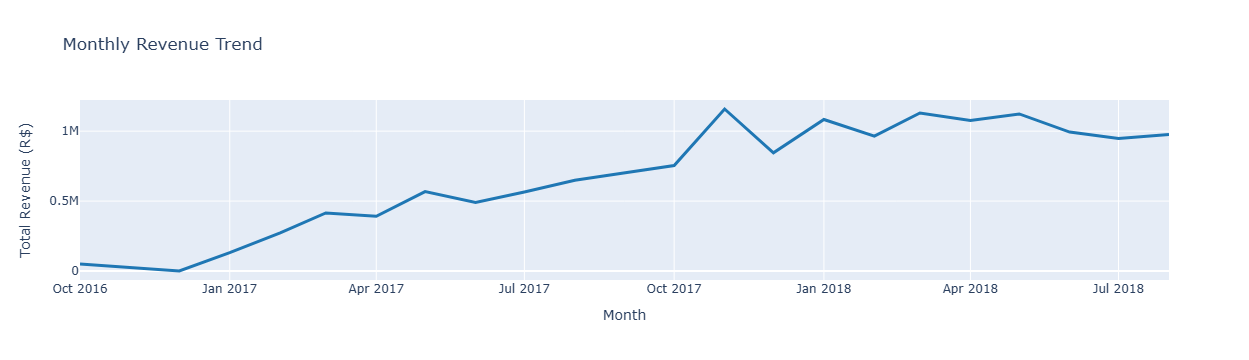

In [7]:
fig = px.line(df_revenue, 
              x='revenue_date', 
              y='total_revenue',
              title="Monthly Revenue Trend")
fig.update_traces(line_color='#1f77b4', line_width=3)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}monthly_revenue_trend.png")

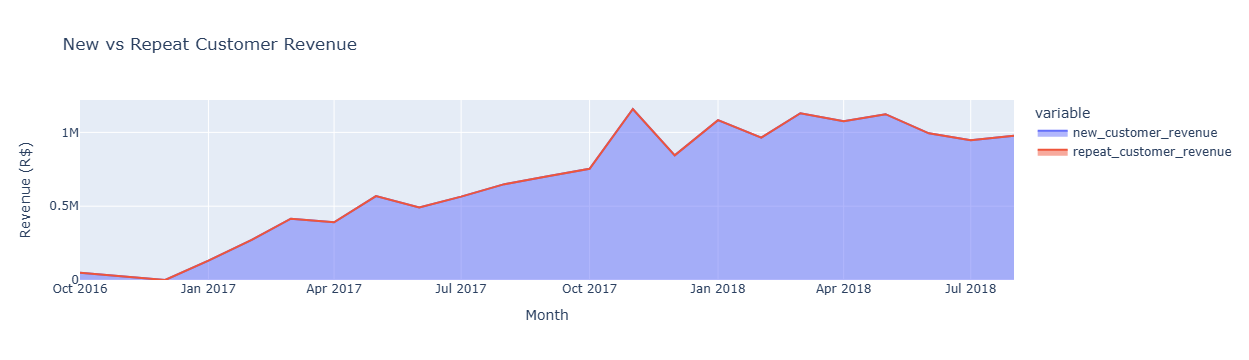

In [8]:
fig = px.area(df_revenue, 
              x='revenue_date', 
              y=['new_customer_revenue', 'repeat_customer_revenue'],
              title="New vs Repeat Customer Revenue")
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}new_vs_repeat_revenue.png")

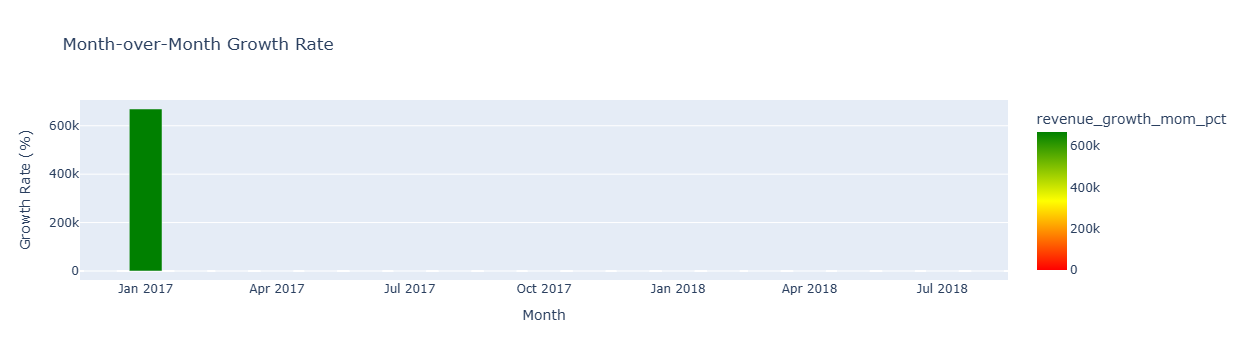

In [9]:
df_revenue_growth = df_revenue[df_revenue['revenue_growth_mom_pct'].notna()].copy()

fig = px.bar(df_revenue_growth, 
             x='revenue_date', 
             y='revenue_growth_mom_pct',
             title="Month-over-Month Growth Rate",
             color='revenue_growth_mom_pct',
             color_continuous_scale=['red', 'yellow', 'green'])
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Growth Rate (%)')
fig.show()
fig.write_image(f"{figures_dir}mom_growth_rate.png")

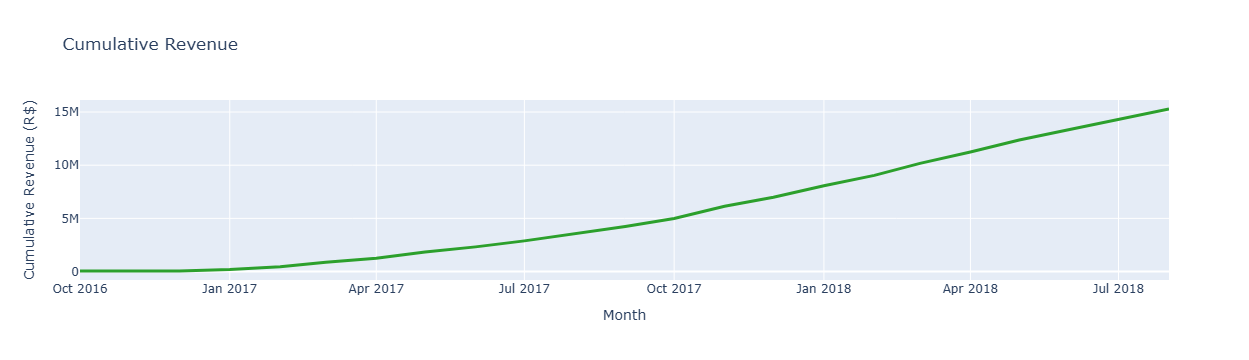

In [10]:
fig = px.line(df_revenue, 
              x='revenue_date', 
              y='cumulative_revenue',
              title="Cumulative Revenue")
fig.update_traces(line_color='#2ca02c', line_width=3)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Cumulative Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}cumulative_revenue.png")

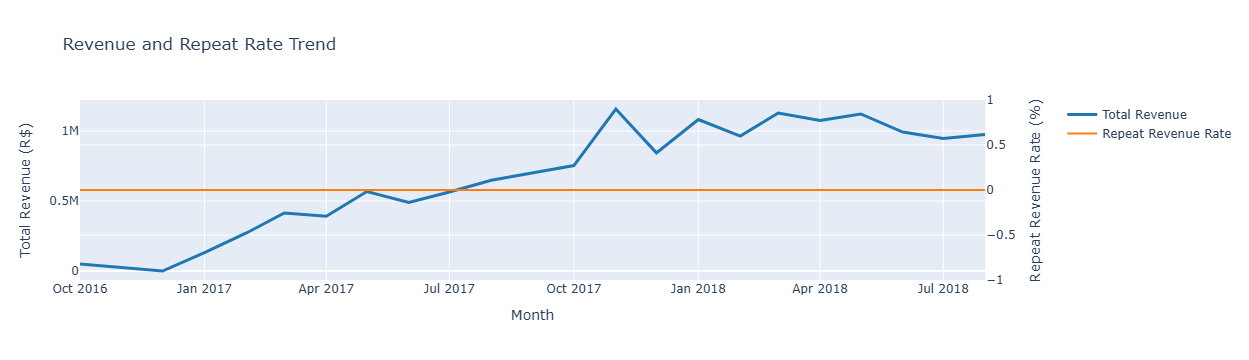

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_revenue['revenue_date'], 
               y=df_revenue['total_revenue'], 
               name="Total Revenue",
               line=dict(color='#1f77b4', width=3)),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_revenue['revenue_date'], 
               y=df_revenue['repeat_revenue_rate'], 
               name="Repeat Revenue Rate",
               line=dict(color='#ff7f0e', width=2)),
    secondary_y=True,
)

fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Total Revenue (R$)", secondary_y=False)
fig.update_yaxes(title_text="Repeat Revenue Rate (%)", secondary_y=True)
fig.update_layout(title_text="Revenue and Repeat Rate Trend")
fig.show()
fig.write_image(f"{figures_dir}revenue_repeat_rate_dual_axis.png")

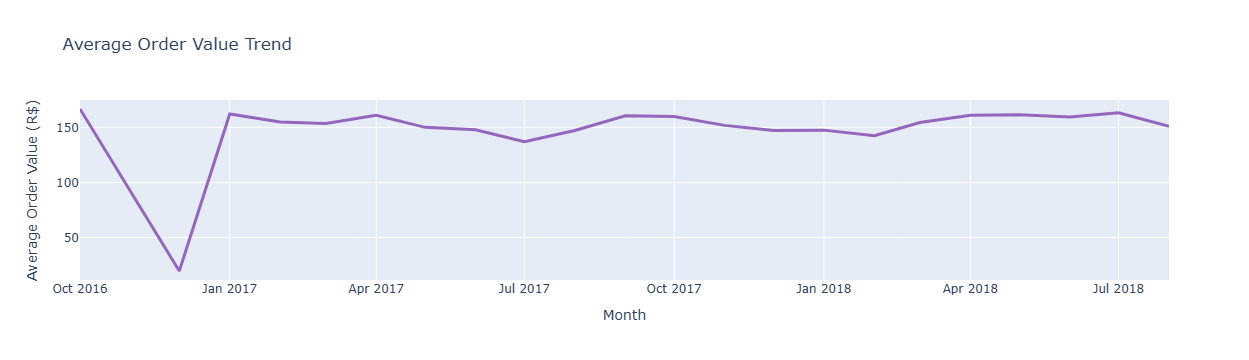

In [12]:
fig = px.line(df_revenue, 
              x='revenue_date', 
              y='avg_order_value',
              title="Average Order Value Trend")
fig.update_traces(line_color='#9467bd', line_width=3)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Average Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_trend.png")

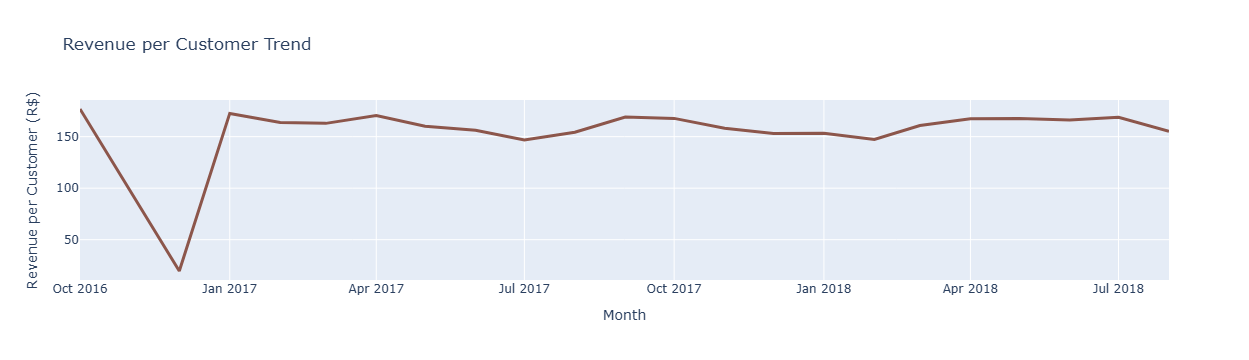

In [13]:
fig = px.line(df_revenue, 
              x='revenue_date', 
              y='revenue_per_customer',
              title="Revenue per Customer Trend")
fig.update_traces(line_color='#8c564b', line_width=3)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Revenue per Customer (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_per_customer_trend.png")

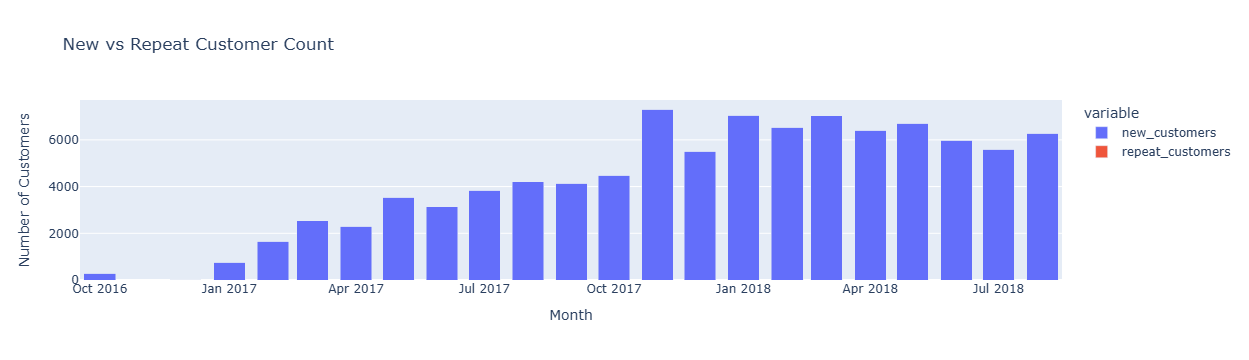

In [14]:
fig = px.bar(df_revenue, 
             x='revenue_date', 
             y=['new_customers', 'repeat_customers'],
             title="New vs Repeat Customer Count",
             barmode='stack')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Number of Customers')
fig.show()
fig.write_image(f"{figures_dir}new_vs_repeat_customers.png")

In [15]:
revenue_summary = df_revenue[['revenue_date', 'total_revenue', 'new_customer_revenue', 
                               'repeat_customer_revenue', 'total_orders', 'total_customers',
                               'avg_order_value', 'revenue_growth_mom_pct']].copy()
revenue_summary.to_csv(f'{exports_dir}revenue_trends.csv', index=False)
print("Revenue trends exported successfully")

Revenue trends exported successfully


## 6. Unit Economics by Segment

In [16]:
overall_ltv = df_unit_economics['avg_ltv'].mean()
overall_cac = df_unit_economics['avg_cac_proxy'].mean()
overall_ltv_cac_ratio = df_unit_economics['avg_ltv_cac_ratio'].mean()
overall_payback_months = df_unit_economics['avg_payback_months'].mean()
overall_contribution_margin = df_unit_economics['avg_contribution_margin'].mean()
overall_margin_pct = df_unit_economics['avg_margin_pct'].mean()

print(f"Overall Average LTV: R$ {overall_ltv:.2f}")
print(f"Overall Average CAC: R$ {overall_cac:.2f}")
print(f"Overall LTV/CAC Ratio: {overall_ltv_cac_ratio:.2f}")
print(f"Overall Payback Period: {overall_payback_months:.2f} months")
print(f"Overall Contribution Margin: R$ {overall_contribution_margin:.2f}")
print(f"Overall Margin: {overall_margin_pct:.2f}%")

Overall Average LTV: R$ 183.01
Overall Average CAC: R$ 50.00
Overall LTV/CAC Ratio: 3.66
Overall Payback Period: nan months
Overall Contribution Margin: R$ 73.98
Overall Margin: 62.53%


In [17]:
df_rfm = df_unit_economics[df_unit_economics['segmentation_type'] == 'RFM Segment'].copy()
df_state = df_unit_economics[df_unit_economics['segmentation_type'] == 'State'].copy()
df_region = df_unit_economics[df_unit_economics['segmentation_type'] == 'Region'].copy()
df_cohort = df_unit_economics[df_unit_economics['segmentation_type'] == 'Cohort'].copy()

print(f"RFM segments: {len(df_rfm)}")
print(f"States: {len(df_state)}")
print(f"Regions: {len(df_region)}")
print(f"Cohorts: {len(df_cohort)}")

RFM segments: 12
States: 27
Regions: 5
Cohorts: 8


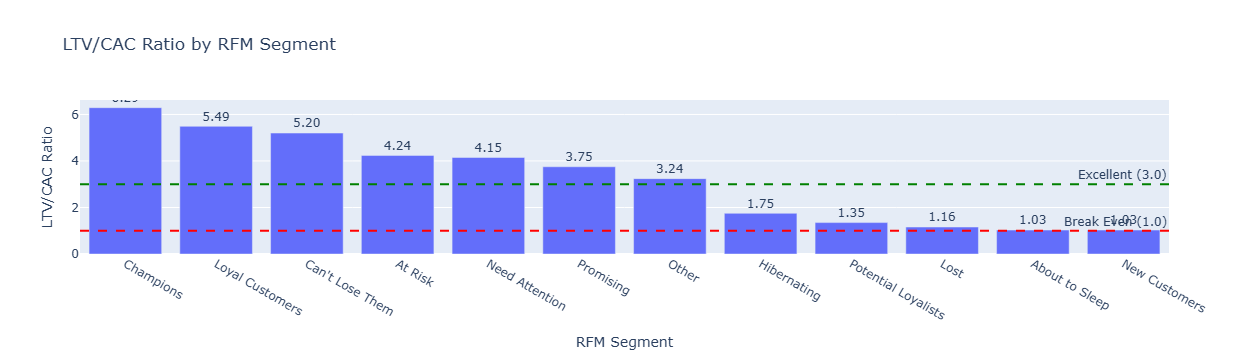

In [18]:
df_rfm_sorted = df_rfm.sort_values('avg_ltv_cac_ratio', ascending=False)

fig = px.bar(df_rfm_sorted, 
             x='segment_name', 
             y='avg_ltv_cac_ratio',
             title="LTV/CAC Ratio by RFM Segment",
             text='avg_ltv_cac_ratio')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_xaxes(title='RFM Segment')
fig.update_yaxes(title='LTV/CAC Ratio')
fig.add_hline(y=3, line_dash="dash", line_color="green", annotation_text="Excellent (3.0)")
fig.add_hline(y=1, line_dash="dash", line_color="red", annotation_text="Break Even (1.0)")
fig.show()
fig.write_image(f"{figures_dir}ltv_cac_ratio_by_rfm.png")

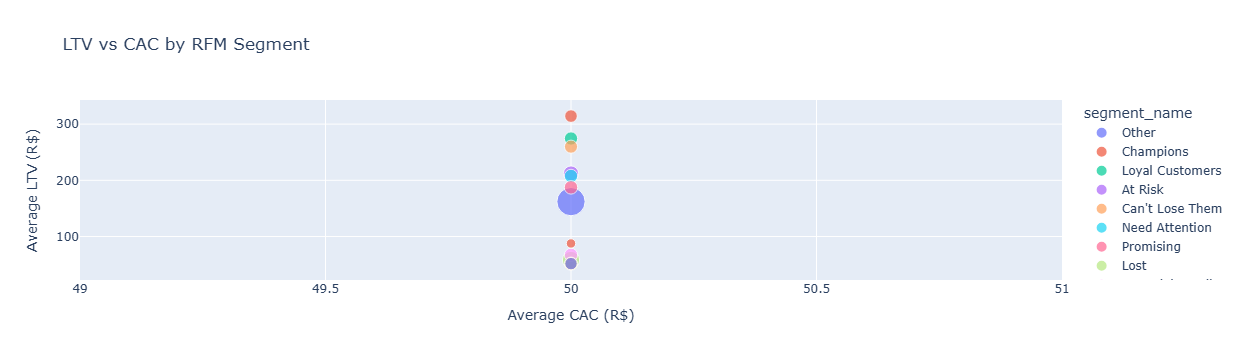

In [19]:
fig = px.scatter(df_rfm, 
                 x='avg_cac_proxy', 
                 y='avg_ltv',
                 size='num_customers',
                 color='segment_name',
                 title="LTV vs CAC by RFM Segment",
                 hover_data=['avg_ltv_cac_ratio'])
fig.update_xaxes(title='Average CAC (R$)')
fig.update_yaxes(title='Average LTV (R$)')
fig.show()
fig.write_image(f"{figures_dir}ltv_vs_cac_scatter.png")

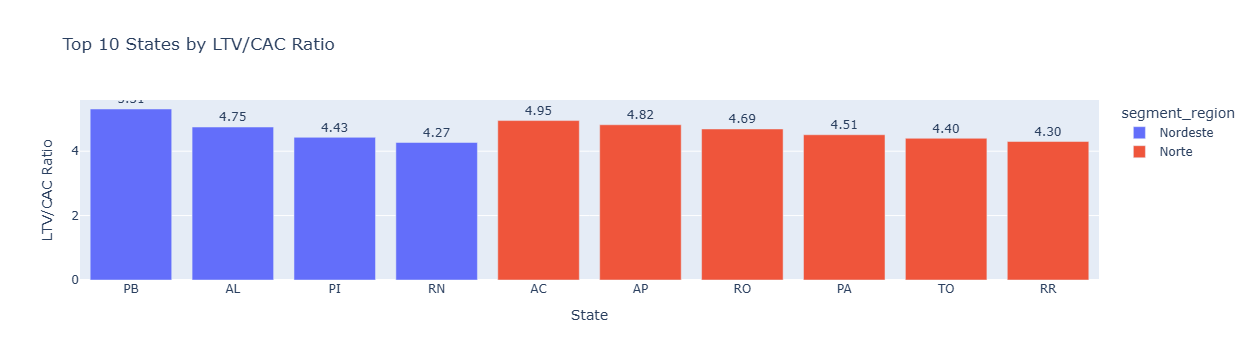

In [20]:
df_state_top10 = df_state.nlargest(10, 'avg_ltv_cac_ratio')

fig = px.bar(df_state_top10, 
             x='segment_name', 
             y='avg_ltv_cac_ratio',
             title="Top 10 States by LTV/CAC Ratio",
             text='avg_ltv_cac_ratio',
             color='segment_region')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_xaxes(title='State')
fig.update_yaxes(title='LTV/CAC Ratio')
fig.show()
fig.write_image(f"{figures_dir}top10_states_ltv_cac.png")

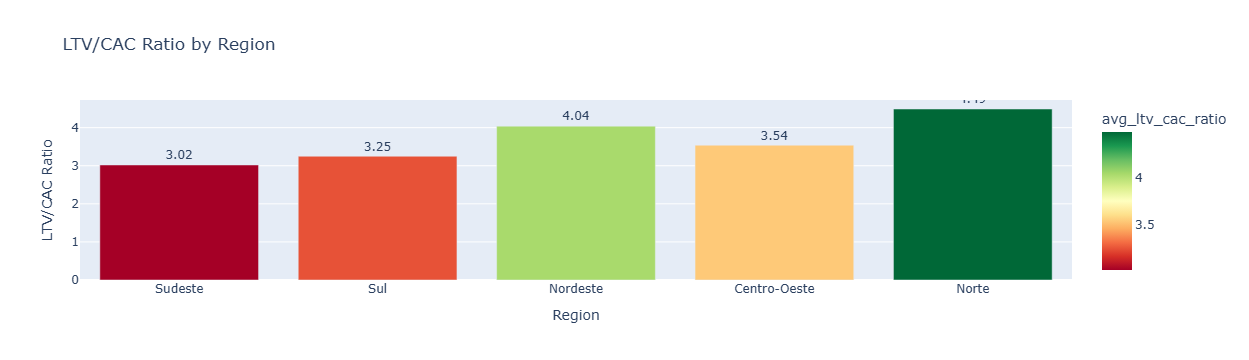

In [21]:
df_region_pivot = df_region.pivot_table(
    values='avg_ltv_cac_ratio',
    index='segment_name',
    aggfunc='mean'
).reset_index()

fig = px.bar(df_region, 
             x='segment_name', 
             y='avg_ltv_cac_ratio',
             title="LTV/CAC Ratio by Region",
             text='avg_ltv_cac_ratio',
             color='avg_ltv_cac_ratio',
             color_continuous_scale='RdYlGn')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_xaxes(title='Region')
fig.update_yaxes(title='LTV/CAC Ratio')
fig.show()
fig.write_image(f"{figures_dir}ltv_cac_by_region.png")

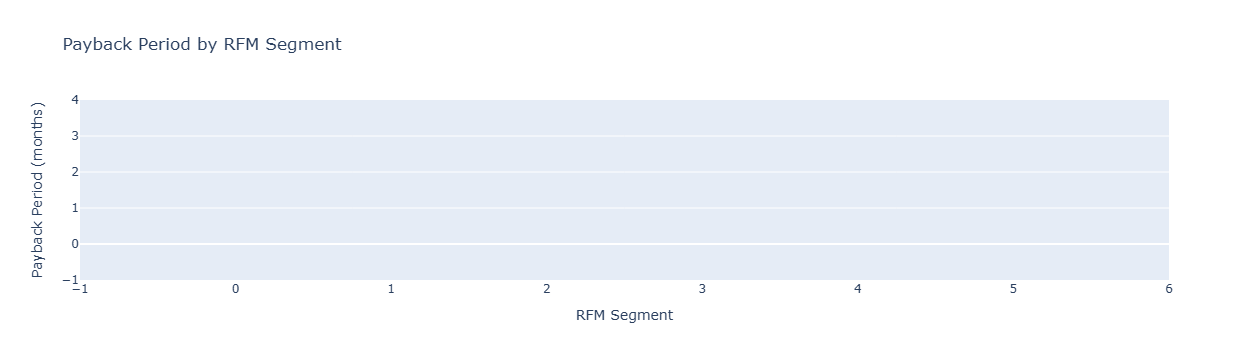

In [22]:
df_rfm_payback = df_rfm[df_rfm['avg_payback_months'].notna()].copy()
df_rfm_payback = df_rfm_payback.sort_values('avg_payback_months')

fig = px.bar(df_rfm_payback, 
             x='segment_name', 
             y='avg_payback_months',
             title="Payback Period by RFM Segment",
             text='avg_payback_months')
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.update_xaxes(title='RFM Segment')
fig.update_yaxes(title='Payback Period (months)')
fig.show()
fig.write_image(f"{figures_dir}payback_period_by_rfm.png")

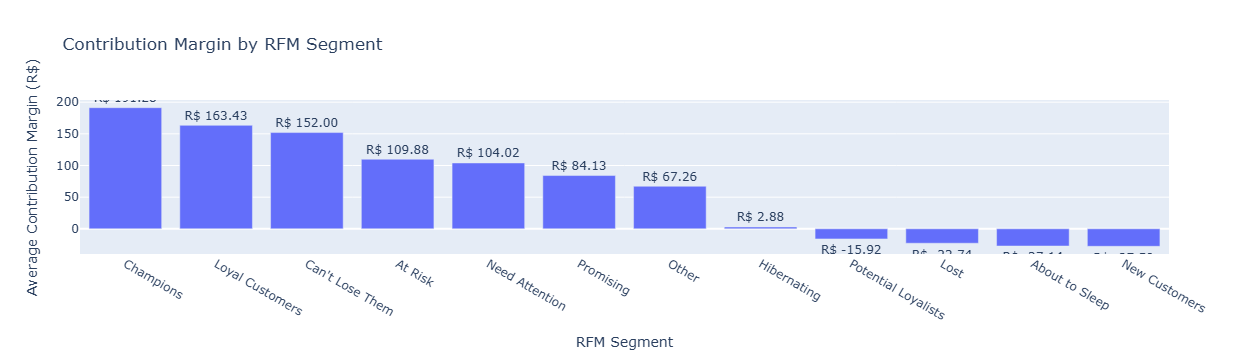

In [23]:
df_rfm_sorted_margin = df_rfm.sort_values('avg_contribution_margin', ascending=False)

fig = px.bar(df_rfm_sorted_margin, 
             x='segment_name', 
             y='avg_contribution_margin',
             title="Contribution Margin by RFM Segment",
             text='avg_contribution_margin')
fig.update_traces(texttemplate='R$ %{text:.2f}', textposition='outside')
fig.update_xaxes(title='RFM Segment')
fig.update_yaxes(title='Average Contribution Margin (R$)')
fig.show()
fig.write_image(f"{figures_dir}contribution_margin_by_rfm.png")

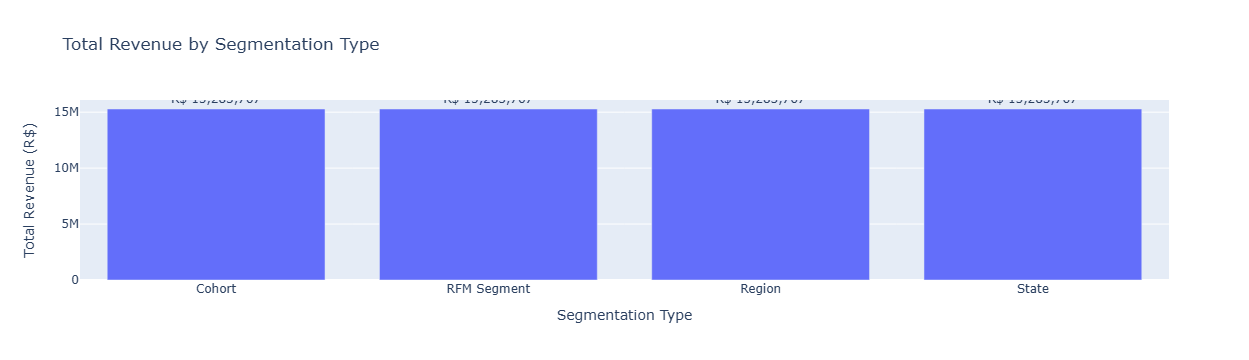

In [24]:
revenue_by_seg_type = df_unit_economics.groupby('segmentation_type')['total_revenue'].sum().reset_index()

fig = px.bar(revenue_by_seg_type, 
             x='segmentation_type', 
             y='total_revenue',
             title="Total Revenue by Segmentation Type",
             text='total_revenue')
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='Segmentation Type')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_by_segmentation_type.png")

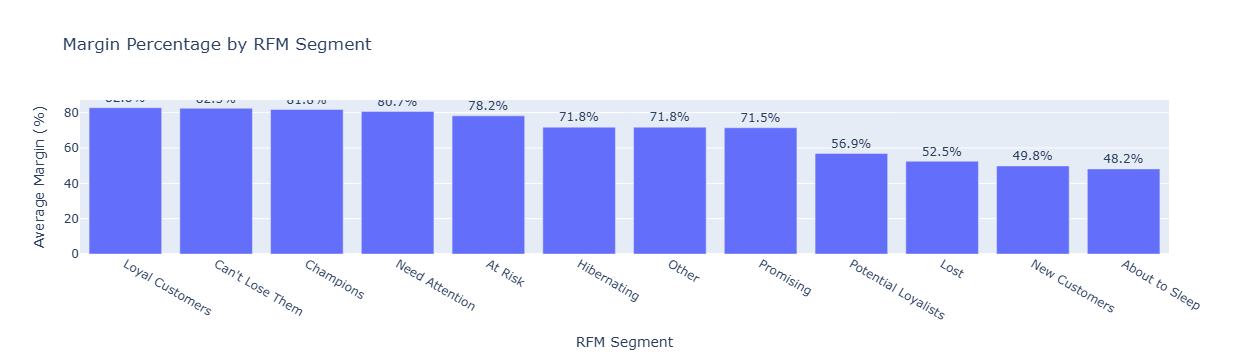

In [25]:
fig = px.bar(df_rfm.sort_values('avg_margin_pct', ascending=False), 
             x='segment_name', 
             y='avg_margin_pct',
             title="Margin Percentage by RFM Segment",
             text='avg_margin_pct')
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_xaxes(title='RFM Segment')
fig.update_yaxes(title='Average Margin (%)')
fig.show()
fig.write_image(f"{figures_dir}margin_pct_by_rfm.png")

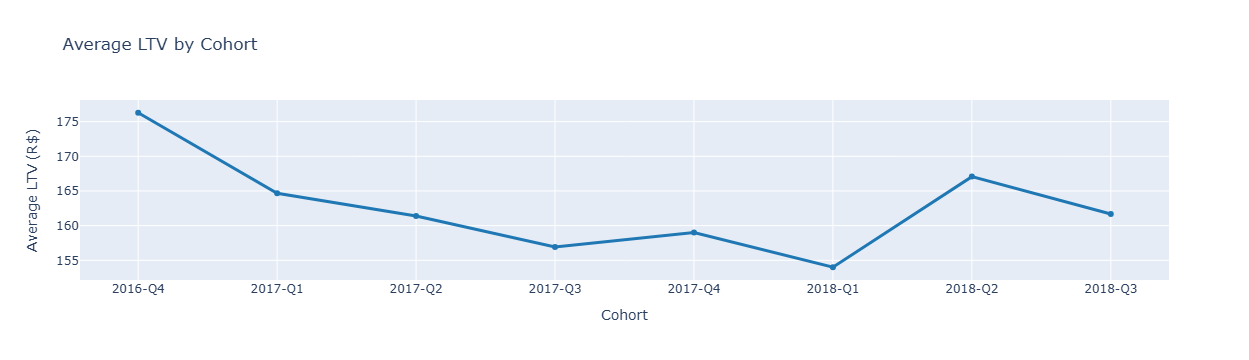

In [26]:
df_cohort_sorted = df_cohort.sort_values('segment_name')

fig = px.line(df_cohort_sorted, 
              x='segment_name', 
              y='avg_ltv',
              title="Average LTV by Cohort",
              markers=True)
fig.update_traces(line_color='#1f77b4', line_width=3)
fig.update_xaxes(title='Cohort')
fig.update_yaxes(title='Average LTV (R$)')
fig.show()
fig.write_image(f"{figures_dir}ltv_by_cohort.png")

In [27]:
unit_economics_summary = df_unit_economics[['segmentation_type', 'segment_name', 'num_customers',
                                             'avg_ltv', 'avg_cac_proxy', 'avg_ltv_cac_ratio',
                                             'avg_payback_months', 'avg_contribution_margin',
                                             'avg_margin_pct', 'total_revenue']].copy()
unit_economics_summary.to_csv(f'{exports_dir}unit_economics_by_segment.csv', index=False)
print("Unit economics data exported successfully")

Unit economics data exported successfully


## 7. Profitability Analysis

In [28]:
def categorize_profitability(ratio):
    if ratio >= 3:
        return 'Excellent'
    elif ratio >= 2:
        return 'Good'
    elif ratio >= 1:
        return 'Break Even'
    else:
        return 'Loss'

df_unit_economics['profitability_category'] = df_unit_economics['avg_ltv_cac_ratio'].apply(categorize_profitability)

profitability_summary = df_unit_economics.groupby('profitability_category').agg({
    'num_customers': 'sum',
    'total_revenue': 'sum',
    'avg_ltv': 'mean',
    'avg_ltv_cac_ratio': 'mean'
}).reset_index()

print(profitability_summary)

  profitability_category  num_customers  total_revenue  avg_ltv  \
0             Break Even          30516     1847115.36    63.28   
1              Excellent         311084    53566713.75   196.90   
2                   Good          40075     5721238.73   142.76   

   avg_ltv_cac_ratio  
0               1.26  
1               3.94  
2               2.86  


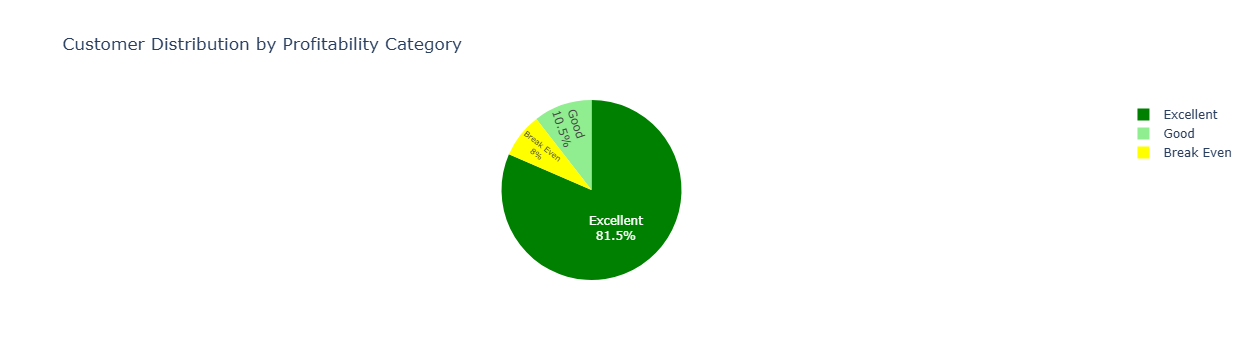

In [29]:
fig = px.pie(profitability_summary, 
             values='num_customers', 
             names='profitability_category',
             title="Customer Distribution by Profitability Category",
             color='profitability_category',
             color_discrete_map={'Excellent': 'green', 'Good': 'lightgreen', 
                                  'Break Even': 'yellow', 'Loss': 'red'})
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()
fig.write_image(f"{figures_dir}customers_by_profitability.png")

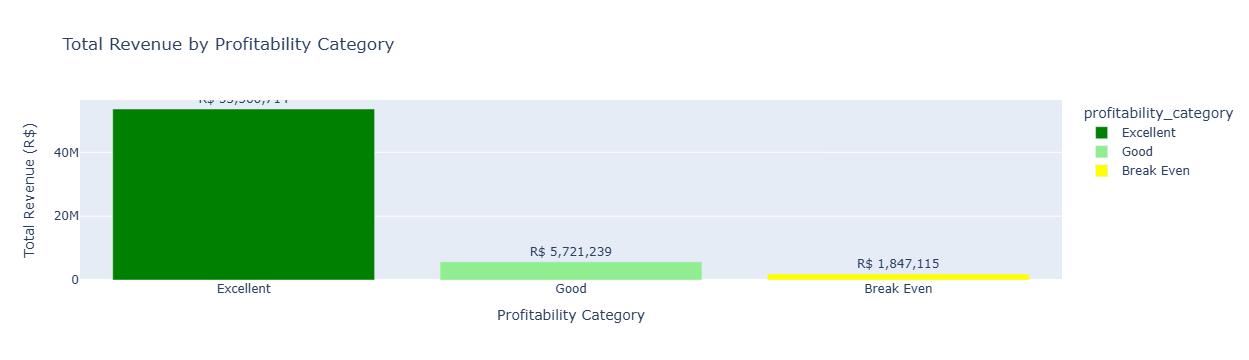

In [30]:
fig = px.bar(profitability_summary.sort_values('total_revenue', ascending=False), 
             x='profitability_category', 
             y='total_revenue',
             title="Total Revenue by Profitability Category",
             text='total_revenue',
             color='profitability_category',
             color_discrete_map={'Excellent': 'green', 'Good': 'lightgreen', 
                                  'Break Even': 'yellow', 'Loss': 'red'})
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='Profitability Category')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_by_profitability.png")

In [31]:
df_profitable = df_unit_economics[df_unit_economics['num_customers'] >= 100].copy()
df_top5_profitable = df_profitable.nlargest(5, 'avg_ltv_cac_ratio')

print("Top 5 Most Profitable Segments:")
print(df_top5_profitable[['segmentation_type', 'segment_name', 'num_customers', 
                           'avg_ltv', 'avg_ltv_cac_ratio', 'avg_contribution_margin']])

Top 5 Most Profitable Segments:
   segmentation_type     segment_name  num_customers  avg_ltv  \
10       RFM Segment        Champions           5470   314.31   
11       RFM Segment  Loyal Customers           6071   274.40   
41             State               PB            510   265.31   
13       RFM Segment  Can't Lose Them           5893   259.84   
45             State               AL            395   237.26   

    avg_ltv_cac_ratio  avg_contribution_margin  
10               6.29                   191.28  
11               5.49                   163.43  
41               5.31                   118.39  
13               5.20                   152.00  
45               4.75                   109.96  


In [32]:
profitability_export = df_unit_economics[['segmentation_type', 'segment_name', 'num_customers',
                                           'avg_ltv_cac_ratio', 'profitability_category',
                                           'avg_contribution_margin', 'total_revenue']].copy()
profitability_export.to_csv(f'{exports_dir}profitability_analysis.csv', index=False)
print("Profitability analysis exported successfully")

Profitability analysis exported successfully


## 8. P&L Proxy

In [33]:
total_customers = df_unit_economics['num_customers'].sum()
gross_revenue = df_unit_economics['avg_gross_revenue'].sum()
total_freight = df_unit_economics['avg_total_freight'].sum()
net_revenue = df_unit_economics['avg_net_revenue'].sum()

cac_total = total_customers * 50
variable_costs = gross_revenue * 0.60
freight_cost = total_freight * 0.80

contribution_margin = net_revenue - variable_costs - cac_total
margin_pct = (contribution_margin / gross_revenue) * 100

print("P&L PROXY SUMMARY")
print("=" * 50)
print(f"Gross Revenue: R$ {gross_revenue:,.2f}")
print(f"Total Freight: R$ {total_freight:,.2f}")
print(f"Net Revenue: R$ {net_revenue:,.2f}")
print(f"")
print(f"Variable Costs (60% proxy): R$ {variable_costs:,.2f}")
print(f"CAC Total: R$ {cac_total:,.2f}")
print(f"Freight Cost (80% proxy): R$ {freight_cost:,.2f}")
print(f"")
print(f"Contribution Margin: R$ {contribution_margin:,.2f}")
print(f"Margin %: {margin_pct:.2f}%")

P&L PROXY SUMMARY
Gross Revenue: R$ 7,980.16
Total Freight: R$ 1,533.40
Net Revenue: R$ 6,446.77

Variable Costs (60% proxy): R$ 4,788.10
CAC Total: R$ 19,083,750.00
Freight Cost (80% proxy): R$ 1,226.72

Contribution Margin: R$ -19,082,091.33
Margin %: -239119.16%


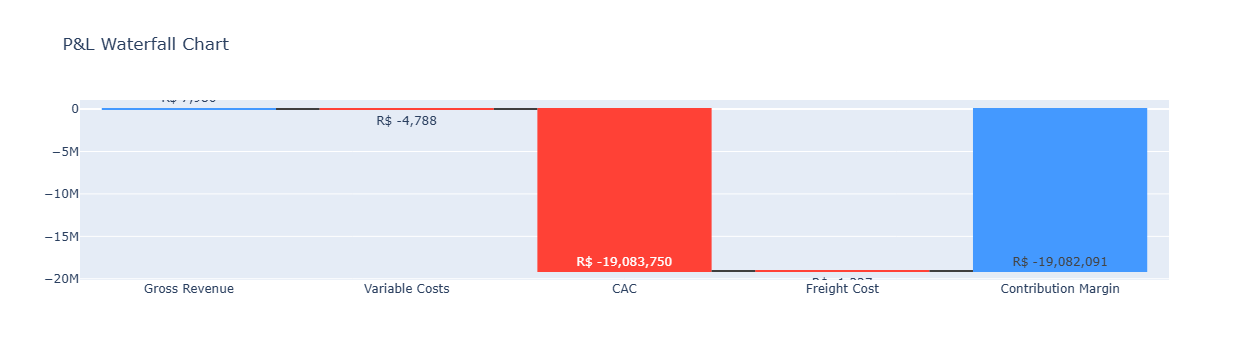

In [34]:
pl_components = [
    ('Gross Revenue', gross_revenue),
    ('Variable Costs', -variable_costs),
    ('CAC', -cac_total),
    ('Freight Cost', -freight_cost),
    ('Contribution Margin', contribution_margin)
]

x_labels = [item[0] for item in pl_components]
y_values = [item[1] for item in pl_components]

fig = go.Figure(go.Waterfall(
    name="P&L",
    orientation="v",
    measure=["absolute", "relative", "relative", "relative", "total"],
    x=x_labels,
    text=[f"R$ {val:,.0f}" for val in y_values],
    y=y_values,
    connector={"line": {"color": "rgb(63, 63, 63)"}},
))

fig.update_layout(title="P&L Waterfall Chart")
fig.show()
fig.write_image(f"{figures_dir}pl_waterfall.png")

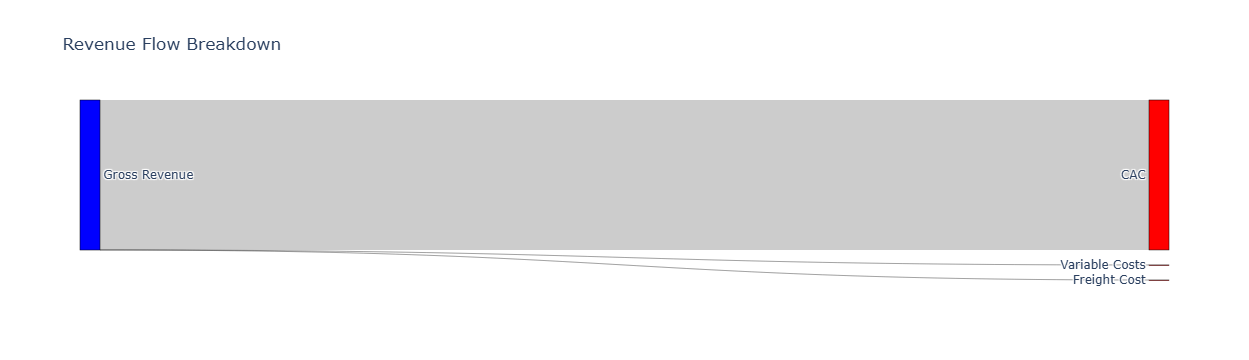

In [35]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["Gross Revenue", "Variable Costs", "CAC", "Freight Cost", "Contribution Margin"],
        color=["blue", "red", "red", "red", "green"]
    ),
    link=dict(
        source=[0, 0, 0, 0],
        target=[1, 2, 3, 4],
        value=[variable_costs, cac_total, freight_cost, contribution_margin]
    )
)])

fig.update_layout(title="Revenue Flow Breakdown")
fig.show()
fig.write_image(f"{figures_dir}revenue_flow_sankey.png")

In [36]:
pl_summary = pd.DataFrame({
    'Component': ['Gross Revenue', 'Total Freight', 'Net Revenue', 
                  'Variable Costs', 'CAC Total', 'Freight Cost', 
                  'Contribution Margin', 'Margin %'],
    'Value': [gross_revenue, total_freight, net_revenue, 
              variable_costs, cac_total, freight_cost, 
              contribution_margin, margin_pct]
})

print(pl_summary.to_string(index=False))

          Component        Value
      Gross Revenue      7980.16
      Total Freight      1533.40
        Net Revenue      6446.77
     Variable Costs      4788.10
          CAC Total  19083750.00
       Freight Cost      1226.72
Contribution Margin -19082091.33
           Margin %   -239119.16


In [37]:
pl_summary.to_csv(f'{exports_dir}pl_proxy.csv', index=False)
print("P&L proxy exported successfully")

P&L proxy exported successfully


## 9. AOV Deep Dive

In [38]:
overall_aov = df_aov['order_value'].mean()
median_aov = df_aov['order_value'].median()
min_aov = df_aov['order_value'].min()
max_aov = df_aov['order_value'].max()
std_aov = df_aov['order_value'].std()

print(f"Overall Average AOV: R$ {overall_aov:.2f}")
print(f"Median AOV: R$ {median_aov:.2f}")
print(f"Min AOV: R$ {min_aov:.2f}")
print(f"Max AOV: R$ {max_aov:.2f}")
print(f"Standard Deviation: R$ {std_aov:.2f}")

Overall Average AOV: R$ 198.60
Median AOV: R$ 109.50
Min AOV: R$ 9.59
Max AOV: R$ 9759.75
Standard Deviation: R$ 364.70


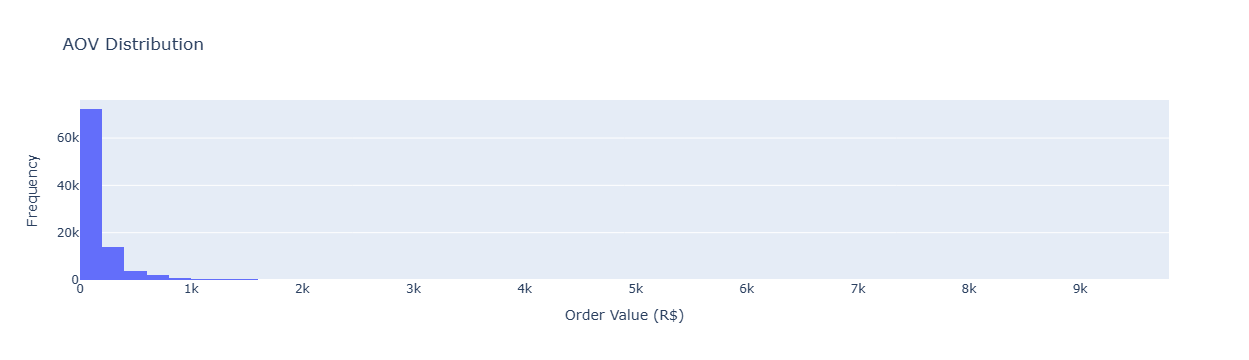

In [39]:
fig = px.histogram(df_aov, 
                   x='order_value',
                   nbins=50,
                   title="AOV Distribution")
fig.update_xaxes(title='Order Value (R$)')
fig.update_yaxes(title='Frequency')
fig.show()
fig.write_image(f"{figures_dir}aov_distribution.png")

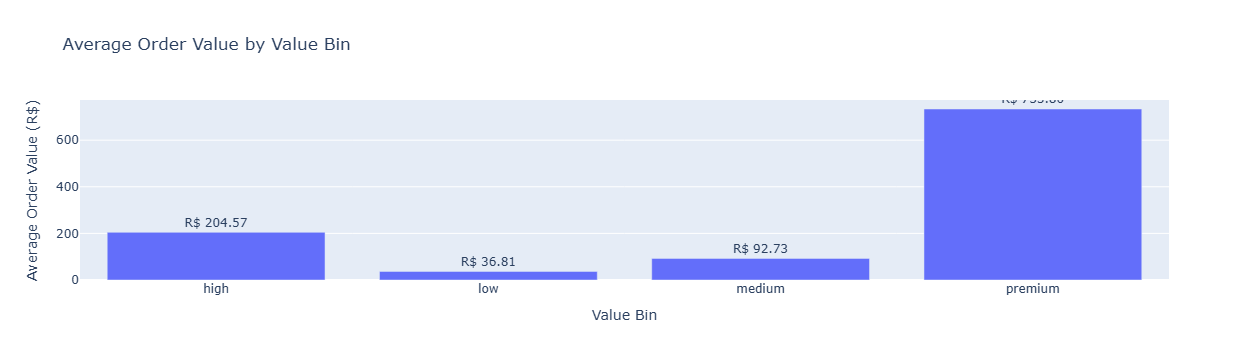

In [40]:
aov_by_value_bin = df_aov.groupby('value_bin')['order_value'].agg(['count', 'mean']).reset_index()
aov_by_value_bin.columns = ['value_bin', 'order_count', 'avg_order_value']

fig = px.bar(aov_by_value_bin, 
             x='value_bin', 
             y='avg_order_value',
             title="Average Order Value by Value Bin",
             text='avg_order_value')
fig.update_traces(texttemplate='R$ %{text:.2f}', textposition='outside')
fig.update_xaxes(title='Value Bin')
fig.update_yaxes(title='Average Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_by_value_bin.png")

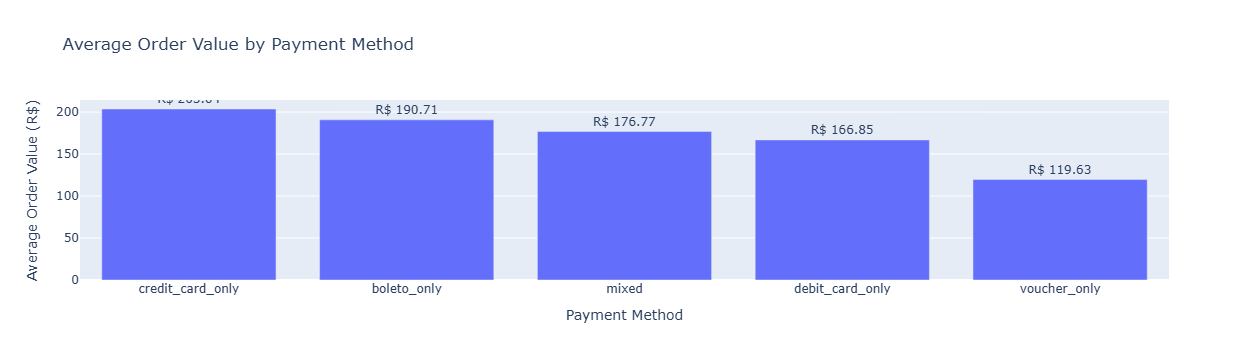

In [41]:
aov_by_payment = df_aov.groupby('payment_method_segment')['order_value'].mean().reset_index()
aov_by_payment = aov_by_payment.sort_values('order_value', ascending=False)

fig = px.bar(aov_by_payment, 
             x='payment_method_segment', 
             y='order_value',
             title="Average Order Value by Payment Method",
             text='order_value')
fig.update_traces(texttemplate='R$ %{text:.2f}', textposition='outside')
fig.update_xaxes(title='Payment Method')
fig.update_yaxes(title='Average Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_by_payment_method.png")

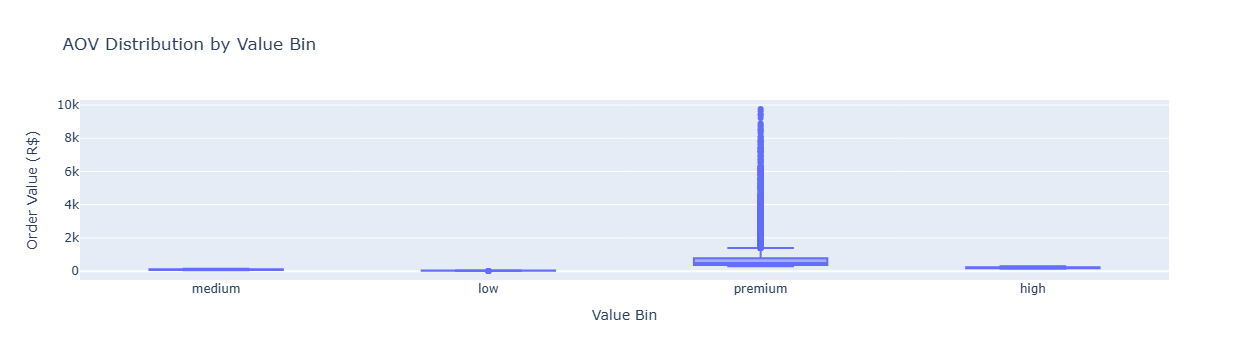

In [42]:
fig = px.box(df_aov, 
             x='value_bin', 
             y='order_value',
             title="AOV Distribution by Value Bin")
fig.update_xaxes(title='Value Bin')
fig.update_yaxes(title='Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_boxplot_by_segment.png")

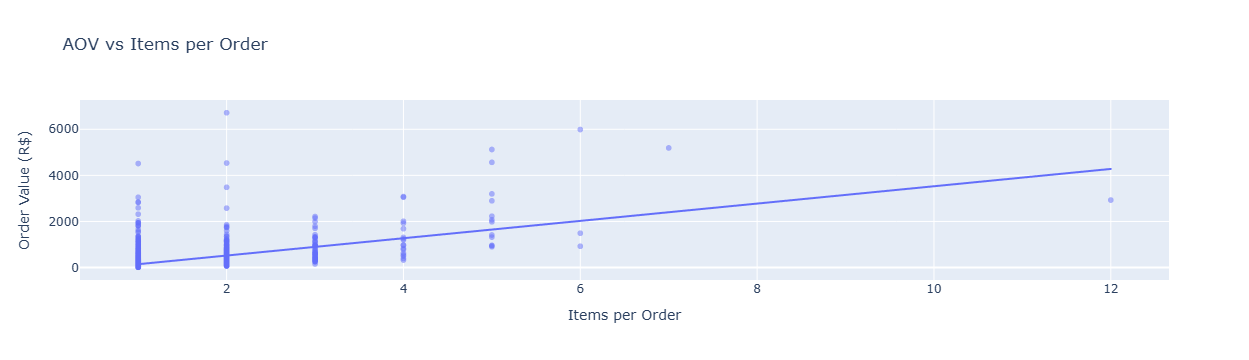

In [43]:
sample_aov = df_aov.sample(n=min(5000, len(df_aov)), random_state=42)

fig = px.scatter(sample_aov, 
                 x='items_per_order', 
                 y='order_value',
                 title="AOV vs Items per Order",
                 trendline="ols",
                 opacity=0.5)
fig.update_xaxes(title='Items per Order')
fig.update_yaxes(title='Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_vs_items_scatter.png")

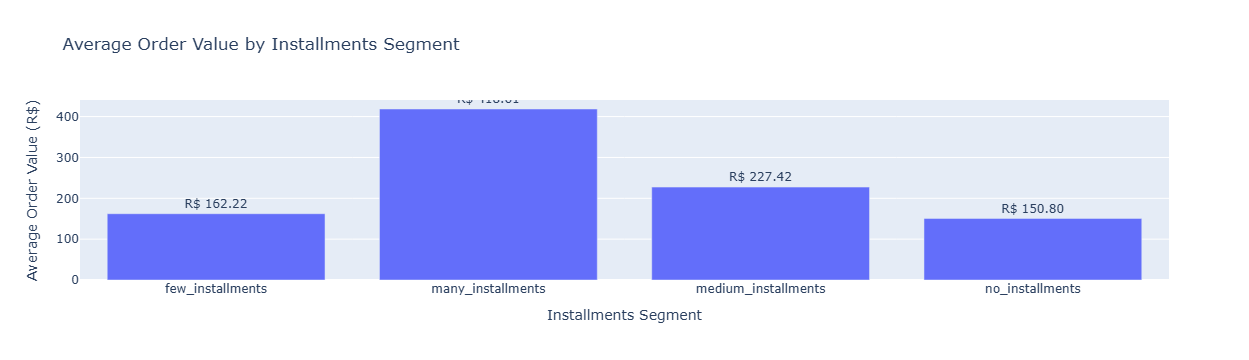

In [44]:
aov_by_installments = df_aov.groupby('installments_segment')['order_value'].mean().reset_index()

fig = px.bar(aov_by_installments, 
             x='installments_segment', 
             y='order_value',
             title="Average Order Value by Installments Segment",
             text='order_value')
fig.update_traces(texttemplate='R$ %{text:.2f}', textposition='outside')
fig.update_xaxes(title='Installments Segment')
fig.update_yaxes(title='Average Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_by_installments.png")

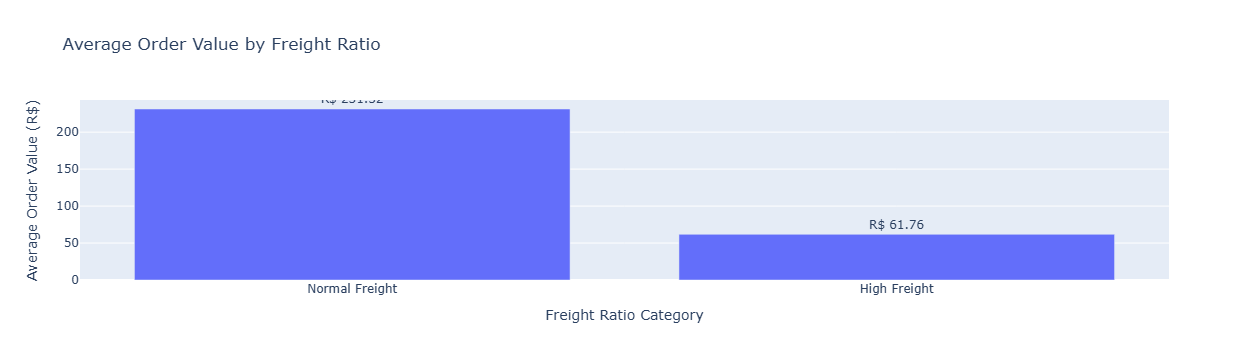

In [45]:
freight_impact = df_aov.groupby('has_high_freight_ratio').agg({
    'order_value': 'mean',
    'order_id': 'count'
}).reset_index()
freight_impact.columns = ['has_high_freight_ratio', 'avg_order_value', 'order_count']
freight_impact['has_high_freight_ratio'] = freight_impact['has_high_freight_ratio'].map({0: 'Normal Freight', 1: 'High Freight'})

fig = px.bar(freight_impact, 
             x='has_high_freight_ratio', 
             y='avg_order_value',
             title="Average Order Value by Freight Ratio",
             text='avg_order_value')
fig.update_traces(texttemplate='R$ %{text:.2f}', textposition='outside')
fig.update_xaxes(title='Freight Ratio Category')
fig.update_yaxes(title='Average Order Value (R$)')
fig.show()
fig.write_image(f"{figures_dir}aov_by_freight_ratio.png")

## 10. Geographic Financial Performance

In [46]:
total_states = len(df_geographic)
top_state = df_geographic.loc[df_geographic['total_revenue'].idxmax(), 'customer_state']
top_state_revenue = df_geographic['total_revenue'].max()

revenue_80pct_threshold = df_geographic['total_revenue'].sum() * 0.80
df_geographic_sorted = df_geographic.sort_values('total_revenue', ascending=False)
df_geographic_sorted['cumulative_revenue'] = df_geographic_sorted['total_revenue'].cumsum()
states_80pct = len(df_geographic_sorted[df_geographic_sorted['cumulative_revenue'] <= revenue_80pct_threshold])

print(f"Total States: {total_states}")
print(f"Top State: {top_state} (R$ {top_state_revenue:,.2f})")
print(f"States representing 80% revenue: {states_80pct} ({states_80pct/total_states*100:.1f}%)")

Total States: 27
Top State: SP (R$ 5,721,238.73)
States representing 80% revenue: 6 (22.2%)


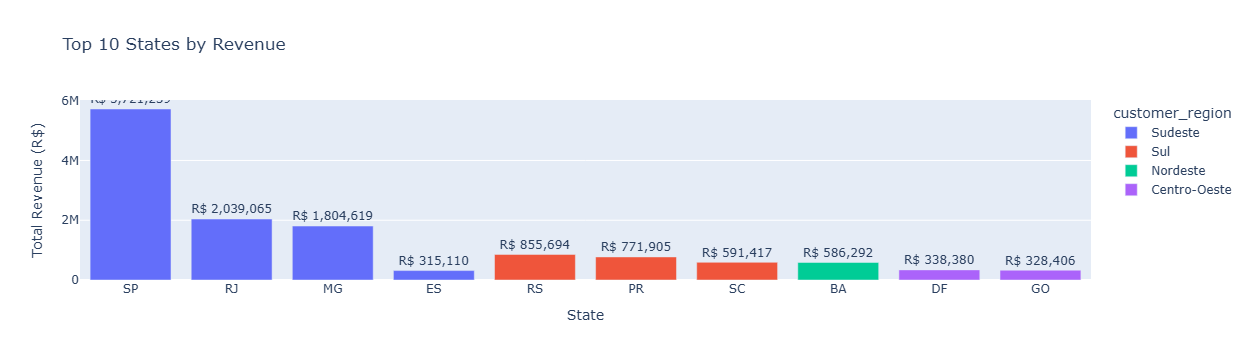

In [47]:
df_top10_states = df_geographic.nlargest(10, 'total_revenue')

fig = px.bar(df_top10_states, 
             x='customer_state', 
             y='total_revenue',
             title="Top 10 States by Revenue",
             text='total_revenue',
             color='customer_region')
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='State')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}top10_states_revenue.png")

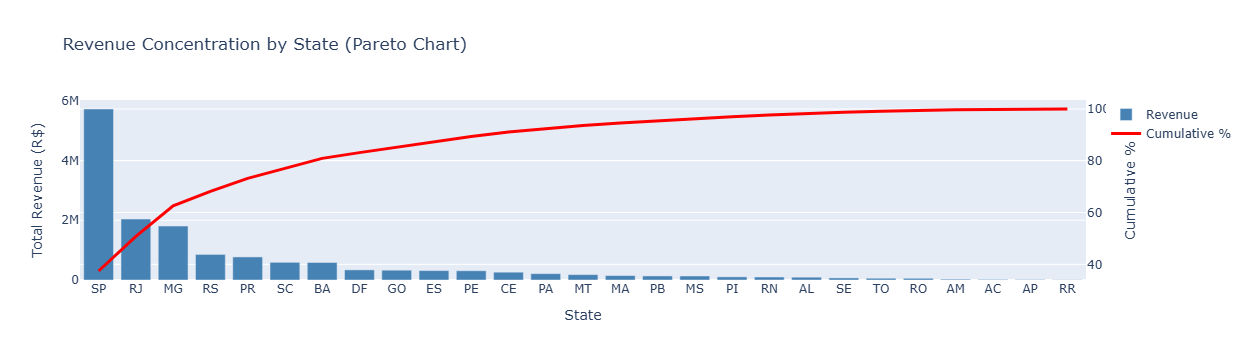

In [48]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_geographic_sorted['customer_state'],
    y=df_geographic_sorted['total_revenue'],
    name='Revenue',
    marker_color='steelblue'
))

fig.add_trace(go.Scatter(
    x=df_geographic_sorted['customer_state'],
    y=df_geographic_sorted['cumulative_revenue_pct'],
    name='Cumulative %',
    yaxis='y2',
    marker_color='red',
    line=dict(width=3)
))

fig.update_layout(
    title='Revenue Concentration by State (Pareto Chart)',
    xaxis=dict(title='State'),
    yaxis=dict(title='Total Revenue (R$)'),
    yaxis2=dict(title='Cumulative %', overlaying='y', side='right'),
    showlegend=True
)

fig.show()
fig.write_image(f"{figures_dir}revenue_concentration_pareto.png")

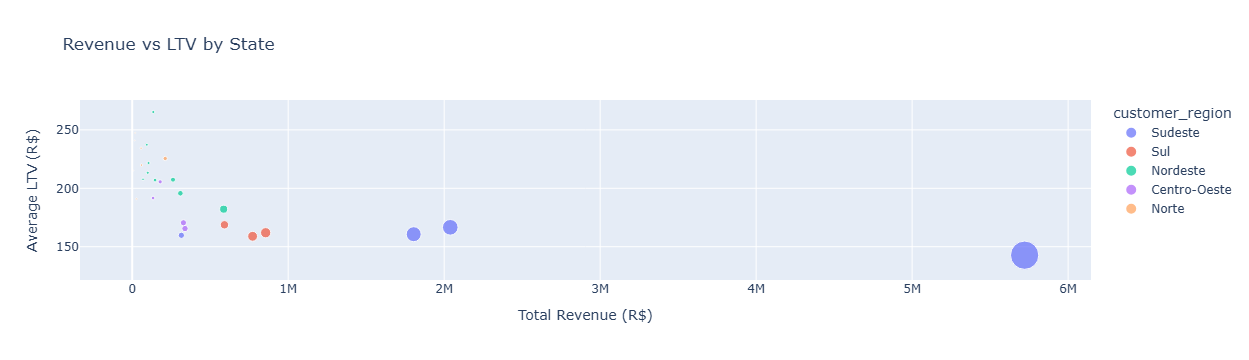

In [49]:
fig = px.scatter(df_geographic, 
                 x='total_revenue', 
                 y='avg_ltv',
                 size='total_customers',
                 color='customer_region',
                 hover_data=['customer_state'],
                 title="Revenue vs LTV by State")
fig.update_xaxes(title='Total Revenue (R$)')
fig.update_yaxes(title='Average LTV (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_vs_ltv_by_state.png")

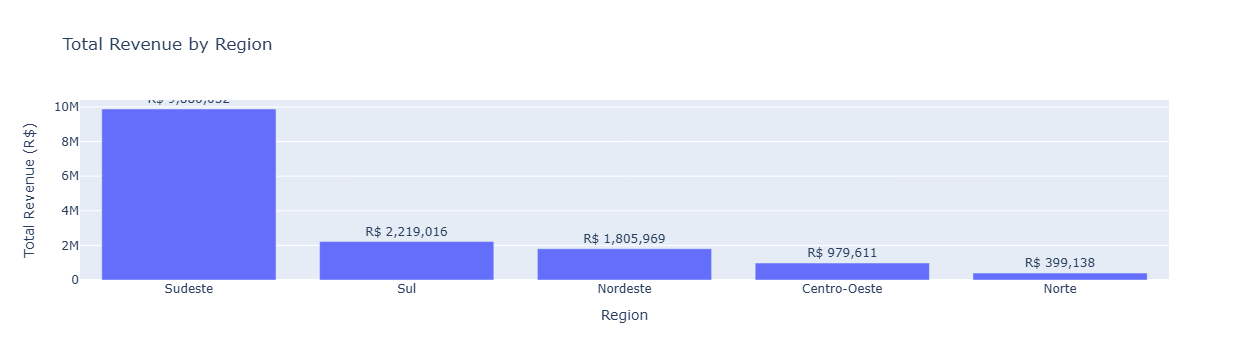

In [50]:
revenue_by_region = df_geographic.groupby('customer_region').agg({
    'total_revenue': 'sum',
    'total_customers': 'sum',
    'avg_ltv': 'mean'
}).reset_index()

fig = px.bar(revenue_by_region.sort_values('total_revenue', ascending=False), 
             x='customer_region', 
             y='total_revenue',
             title="Total Revenue by Region",
             text='total_revenue')
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='Region')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_by_region.png")

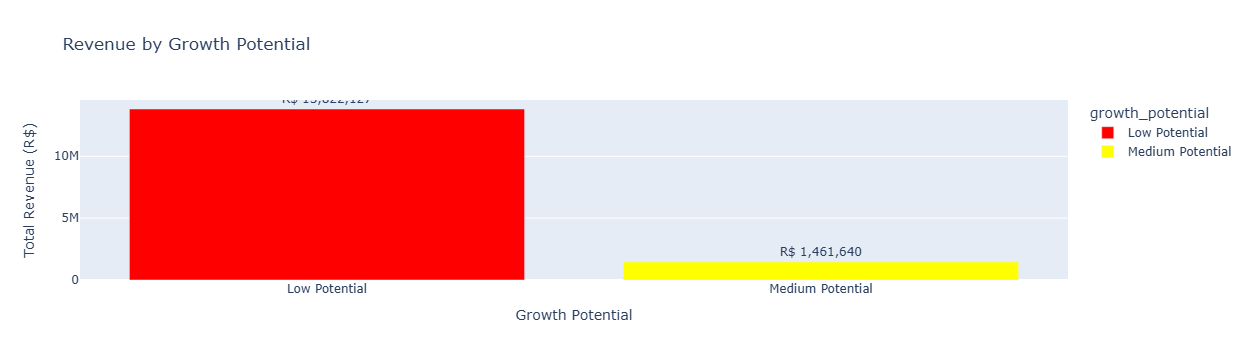

In [51]:
growth_potential_summary = df_geographic.groupby('growth_potential').agg({
    'customer_state': 'count',
    'total_revenue': 'sum',
    'avg_ltv': 'mean',
    'repurchase_rate': 'mean'
}).reset_index()
growth_potential_summary.columns = ['growth_potential', 'num_states', 'total_revenue', 'avg_ltv', 'avg_repurchase_rate']

fig = px.bar(growth_potential_summary, 
             x='growth_potential', 
             y='total_revenue',
             title="Revenue by Growth Potential",
             text='total_revenue',
             color='growth_potential',
             color_discrete_map={'High Potential': 'green', 'Medium Potential': 'yellow', 'Low Potential': 'red'})
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='Growth Potential')
fig.update_yaxes(title='Total Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_by_growth_potential.png")

In [52]:
geographic_export = df_geographic[['customer_state', 'customer_region', 'total_revenue', 
                                    'avg_ltv', 'repurchase_rate', 'revenue_concentration_pct',
                                    'growth_potential', 'ltv_rank', 'revenue_rank']].copy()
geographic_export.to_csv(f'{exports_dir}geographic_performance.csv', index=False)
print("Geographic performance data exported successfully")

Geographic performance data exported successfully


## 11. Scenario Planning & Projections

In [53]:
df_revenue_recent = df_revenue.tail(6)
base_growth_rate = df_revenue_recent['revenue_growth_mom_pct'].mean() / 100
base_retention_rate = df_revenue['repeat_revenue_rate'].mean() / 100
base_cac = 50.0
last_month_revenue = df_revenue['total_revenue'].iloc[-1]
current_customers = df_revenue['total_customers'].iloc[-1]

print("BASE CASE ASSUMPTIONS")
print("=" * 50)
print(f"Average Growth Rate (last 6 months): {base_growth_rate*100:.2f}%")
print(f"Current Retention Rate: {base_retention_rate*100:.2f}%")
print(f"CAC: R$ {base_cac:.2f}")
print(f"Last Month Revenue: R$ {last_month_revenue:,.2f}")
print(f"Current Customers: {current_customers:,.0f}")

BASE CASE ASSUMPTIONS
Average Growth Rate (last 6 months): 0.60%
Current Retention Rate: 0.00%
CAC: R$ 50.00
Last Month Revenue: R$ 976,324.55
Current Customers: 6,288


In [54]:
scenarios = {
    'Base Case': {
        'growth_rate': base_growth_rate,
        'retention_impact': 0.0,
        'cac': base_cac
    },
    'Optimistic': {
        'growth_rate': base_growth_rate * 1.20,
        'retention_impact': 0.10,
        'cac': base_cac * 0.90
    },
    'Pessimistic': {
        'growth_rate': base_growth_rate * 0.80,
        'retention_impact': -0.10,
        'cac': base_cac * 1.20
    }
}

print("SCENARIO DEFINITIONS")
print("=" * 50)
for scenario_name, params in scenarios.items():
    print(f"\n{scenario_name}:")
    print(f"  Growth Rate: {params['growth_rate']*100:.2f}%")
    print(f"  Retention Impact: {params['retention_impact']*100:+.1f}%")
    print(f"  CAC: R$ {params['cac']:.2f}")

SCENARIO DEFINITIONS

Base Case:
  Growth Rate: 0.60%
  Retention Impact: +0.0%
  CAC: R$ 50.00

Optimistic:
  Growth Rate: 0.72%
  Retention Impact: +10.0%
  CAC: R$ 45.00

Pessimistic:
  Growth Rate: 0.48%
  Retention Impact: -10.0%
  CAC: R$ 60.00


In [55]:
projection_months = 12
projections = []

for scenario_name, params in scenarios.items():
    revenue = last_month_revenue
    customers = current_customers
    
    for month in range(1, projection_months + 1):
        revenue = revenue * (1 + params['growth_rate'])
        customers = customers * (1 + params['retention_impact'])
        
        variable_costs = revenue * 0.60
        cac_costs = customers * params['cac'] / 12
        profit = revenue - variable_costs - cac_costs
        
        projections.append({
            'scenario': scenario_name,
            'month': month,
            'projected_revenue': revenue,
            'projected_customers': customers,
            'projected_profit': profit,
            'cac': params['cac']
        })

df_projections = pd.DataFrame(projections)
print(f"Projections generated: {len(df_projections)} records")

Projections generated: 36 records


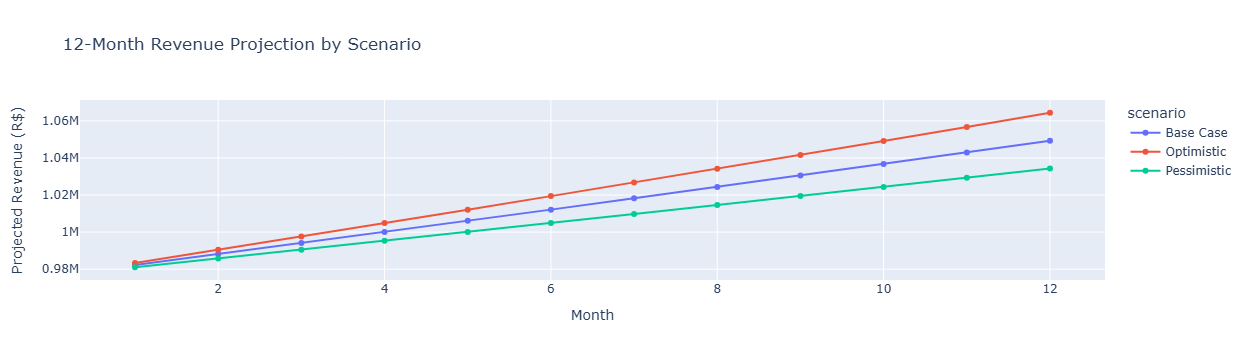

In [56]:
fig = px.line(df_projections, 
              x='month', 
              y='projected_revenue',
              color='scenario',
              title="12-Month Revenue Projection by Scenario",
              markers=True)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Projected Revenue (R$)')
fig.show()
fig.write_image(f"{figures_dir}revenue_projection_scenarios.png")

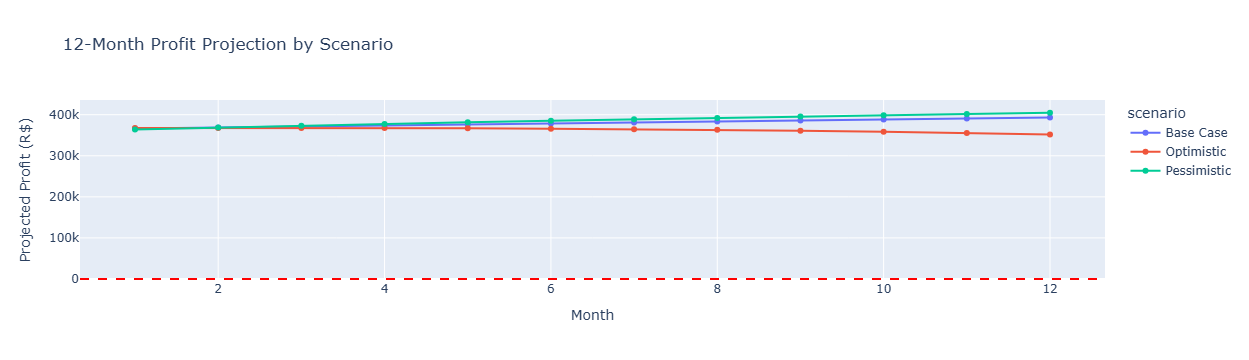

In [57]:
fig = px.line(df_projections, 
              x='month', 
              y='projected_profit',
              color='scenario',
              title="12-Month Profit Projection by Scenario",
              markers=True)
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Projected Profit (R$)')
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()
fig.write_image(f"{figures_dir}profit_projection_scenarios.png")

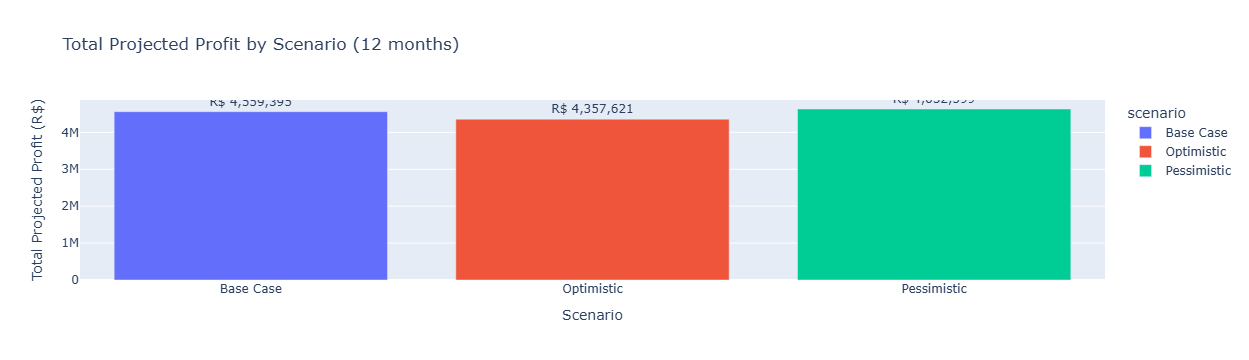


SCENARIO COMPARISON SUMMARY
   scenario  total_projected_revenue  total_projected_profit  final_customers   roi
  Base Case              12184488.63              4559395.45          6288.00 37.42
 Optimistic              12280716.66              4357621.11         19734.44 35.48
Pessimistic              12089107.08              4632599.09          1775.92 38.32


In [58]:
scenario_summary = df_projections.groupby('scenario').agg({
    'projected_revenue': 'sum',
    'projected_profit': 'sum',
    'projected_customers': 'last'
}).reset_index()

scenario_summary.columns = ['scenario', 'total_projected_revenue', 'total_projected_profit', 'final_customers']
scenario_summary['roi'] = (scenario_summary['total_projected_profit'] / scenario_summary['total_projected_revenue']) * 100

fig = px.bar(scenario_summary, 
             x='scenario', 
             y='total_projected_profit',
             title="Total Projected Profit by Scenario (12 months)",
             text='total_projected_profit',
             color='scenario')
fig.update_traces(texttemplate='R$ %{text:,.0f}', textposition='outside')
fig.update_xaxes(title='Scenario')
fig.update_yaxes(title='Total Projected Profit (R$)')
fig.show()
fig.write_image(f"{figures_dir}scenario_profit_comparison.png")

print("\nSCENARIO COMPARISON SUMMARY")
print("=" * 70)
print(scenario_summary.to_string(index=False))

In [59]:
df_projections.to_csv(f'{exports_dir}scenario_projections.csv', index=False)
scenario_summary.to_csv(f'{exports_dir}scenario_summary.csv', index=False)
print("Projection data exported successfully")

Projection data exported successfully


## 12. Executive Summary & Insights

In [60]:
total_revenue_summary = df_revenue['total_revenue'].sum()
avg_monthly_revenue_summary = df_revenue['total_revenue'].mean()
latest_mom_growth = df_revenue['revenue_growth_mom_pct'].iloc[-1]
overall_ltv_summary = df_unit_economics['avg_ltv'].mean()
overall_ltv_cac_summary = df_unit_economics['avg_ltv_cac_ratio'].mean()
overall_payback_summary = df_unit_economics['avg_payback_months'].mean()
contribution_margin_summary = df_unit_economics['avg_contribution_margin'].mean()
margin_pct_summary = df_unit_economics['avg_margin_pct'].mean()

top3_profitable = df_unit_economics[df_unit_economics['num_customers'] >= 100].nlargest(3, 'avg_ltv_cac_ratio')
top3_growth_states = df_geographic[df_geographic['growth_potential'] == 'High Potential'].nlargest(3, 'total_revenue')

new_customer_revenue_pct_summary = (df_revenue['new_customer_revenue'].sum() / total_revenue_summary) * 100
repeat_customer_revenue_pct_summary = (df_revenue['repeat_customer_revenue'].sum() / total_revenue_summary) * 100

base_case_12m_revenue = df_projections[df_projections['scenario'] == 'Base Case']['projected_revenue'].sum()
base_case_12m_profit = df_projections[df_projections['scenario'] == 'Base Case']['projected_profit'].sum()

summary = f"""
FINANCIAL ANALYSIS - EXECUTIVE SUMMARY
{"=" * 70}

REVENUE PERFORMANCE:
  - Total Revenue: R$ {total_revenue_summary:,.2f}
  - Average Monthly Revenue: R$ {avg_monthly_revenue_summary:,.2f}
  - Latest MoM Growth: {latest_mom_growth:.2f}%
  - New Customer Revenue: {new_customer_revenue_pct_summary:.1f}%
  - Repeat Customer Revenue: {repeat_customer_revenue_pct_summary:.1f}%

UNIT ECONOMICS:
  - Average LTV: R$ {overall_ltv_summary:.2f}
  - Average CAC: R$ 50.00
  - LTV/CAC Ratio: {overall_ltv_cac_summary:.2f}x
  - Payback Period: {overall_payback_summary:.1f} months
  - Contribution Margin: R$ {contribution_margin_summary:.2f}
  - Margin Percentage: {margin_pct_summary:.1f}%

PROFITABILITY:
  - Gross Revenue: R$ {gross_revenue:,.2f}
  - Net Revenue: R$ {net_revenue:,.2f}
  - Total Contribution Margin: R$ {contribution_margin:,.2f}
  - Overall Margin: {margin_pct:.2f}%

GEOGRAPHIC PERFORMANCE:
  - Total States: {total_states}
  - Top State: {top_state} (R$ {top_state_revenue:,.2f})
  - States with 80% Revenue: {states_80pct} ({states_80pct/total_states*100:.1f}%)

12-MONTH PROJECTION (BASE CASE):
  - Projected Revenue: R$ {base_case_12m_revenue:,.2f}
  - Projected Profit: R$ {base_case_12m_profit:,.2f}
  - Projected ROI: {(base_case_12m_profit/base_case_12m_revenue)*100:.2f}%

KEY INSIGHTS:

1. PROFITABILITY HEALTH:
   - LTV/CAC ratio of {overall_ltv_cac_summary:.2f}x indicates {"excellent" if overall_ltv_cac_summary >= 3 else "good" if overall_ltv_cac_summary >= 2 else "moderate"} unit economics
   - Payback period of {overall_payback_summary:.1f} months is {"fast" if overall_payback_summary <= 6 else "moderate" if overall_payback_summary <= 12 else "slow"}
   - Contribution margin of {margin_pct:.1f}% shows {"healthy" if margin_pct >= 20 else "moderate" if margin_pct >= 10 else "low"} profitability

2. TOP PROFITABLE SEGMENTS:
   - {top3_profitable.iloc[0]['segment_name']}: LTV/CAC = {top3_profitable.iloc[0]['avg_ltv_cac_ratio']:.2f}x
   - {top3_profitable.iloc[1]['segment_name']}: LTV/CAC = {top3_profitable.iloc[1]['avg_ltv_cac_ratio']:.2f}x
   - {top3_profitable.iloc[2]['segment_name']}: LTV/CAC = {top3_profitable.iloc[2]['avg_ltv_cac_ratio']:.2f}x

3. REVENUE MIX HEALTH:
   - {repeat_customer_revenue_pct_summary:.1f}% from repeat customers indicates {"strong" if repeat_customer_revenue_pct_summary >= 40 else "moderate" if repeat_customer_revenue_pct_summary >= 25 else "weak"} customer retention
   - {"Need to focus on retention strategies" if repeat_customer_revenue_pct_summary < 30 else "Good balance between acquisition and retention"}

4. GEOGRAPHIC EXPANSION OPPORTUNITIES:
   - High potential states: {len(df_geographic[df_geographic['growth_potential'] == 'High Potential'])} states identified
   - Top expansion targets: {', '.join(top3_growth_states['customer_state'].tolist())}

5. FINANCIAL RISKS:
   - Revenue concentration: {states_80pct} states drive 80% of revenue
   - {"High geographic concentration risk" if states_80pct <= 5 else "Moderate geographic diversification"}

STRATEGIC RECOMMENDATIONS:

1. PROFITABILITY OPTIMIZATION:
   - Focus marketing spend on segments with LTV/CAC > 3.0x
   - Reduce CAC in underperforming segments or exit them
   - Invest in retention programs to increase repeat purchase rate

2. REVENUE GROWTH:
   - Expand in high-potential states with proven product-market fit
   - Increase AOV through cross-selling and upselling strategies
   - Target {100 - repeat_customer_revenue_pct_summary:.0f}% new customer acquisition gap

3. GEOGRAPHIC STRATEGY:
   - Diversify revenue base to reduce concentration risk
   - Replicate successful strategies from top states to similar markets
   - Invest in logistics to improve margins in high-freight-cost regions

4. FINANCIAL HEALTH:
   - Monitor payback period quarterly to ensure CAC efficiency
   - Set target LTV/CAC ratio of 3.0x minimum for new segments
   - Implement dynamic pricing to optimize contribution margins

5. SCENARIO PLANNING:
   - Base case projects {(base_case_12m_revenue/total_revenue_summary - 1)*100:.1f}% revenue growth
   - Build contingency plans for pessimistic scenario
   - Prepare to scale operations for optimistic scenario outcomes
"""

print(summary)


FINANCIAL ANALYSIS - EXECUTIVE SUMMARY

REVENUE PERFORMANCE:
  - Total Revenue: R$ 15,283,766.96
  - Average Monthly Revenue: R$ 694,716.68
  - Latest MoM Growth: 3.07%
  - New Customer Revenue: 100.0%
  - Repeat Customer Revenue: 0.0%

UNIT ECONOMICS:
  - Average LTV: R$ 183.01
  - Average CAC: R$ 50.00
  - LTV/CAC Ratio: 3.66x
  - Payback Period: nan months
  - Contribution Margin: R$ 73.98
  - Margin Percentage: 62.5%

PROFITABILITY:
  - Gross Revenue: R$ 7,980.16
  - Net Revenue: R$ 6,446.77
  - Total Contribution Margin: R$ -19,082,091.33
  - Overall Margin: -239119.16%

GEOGRAPHIC PERFORMANCE:
  - Total States: 27
  - Top State: SP (R$ 5,721,238.73)
  - States with 80% Revenue: 6 (22.2%)

12-MONTH PROJECTION (BASE CASE):
  - Projected Revenue: R$ 12,184,488.63
  - Projected Profit: R$ 4,559,395.45
  - Projected ROI: 37.42%

KEY INSIGHTS:

1. PROFITABILITY HEALTH:
   - LTV/CAC ratio of 3.66x indicates excellent unit economics
   - Payback period of nan months is slow
   - Contrib

In [61]:
summary_data = {
    'Metric': [
        'Total Revenue', 'Average Monthly Revenue', 'Latest MoM Growth',
        'Average LTV', 'LTV/CAC Ratio', 'Payback Period',
        'Contribution Margin', 'Margin Percentage',
        'Top State', 'States with 80% Revenue',
        'Base Case 12M Revenue', 'Base Case 12M Profit'
    ],
    'Value': [
        f"R$ {total_revenue_summary:,.2f}",
        f"R$ {avg_monthly_revenue_summary:,.2f}",
        f"{latest_mom_growth:.2f}%",
        f"R$ {overall_ltv_summary:.2f}",
        f"{overall_ltv_cac_summary:.2f}x",
        f"{overall_payback_summary:.1f} months",
        f"R$ {contribution_margin_summary:.2f}",
        f"{margin_pct_summary:.1f}%",
        f"{top_state}",
        f"{states_80pct}",
        f"R$ {base_case_12m_revenue:,.2f}",
        f"R$ {base_case_12m_profit:,.2f}"
    ]
}

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv(f'{exports_dir}financial_summary.csv', index=False)

print("\n" + "=" * 70)
print("ALL EXPORTS COMPLETED SUCCESSFULLY")
print("=" * 70)
print("\nExported files:")
print("  - revenue_trends.csv")
print("  - unit_economics_by_segment.csv")
print("  - profitability_analysis.csv")
print("  - pl_proxy.csv")
print("  - geographic_performance.csv")
print("  - scenario_projections.csv")
print("  - scenario_summary.csv")
print("  - financial_summary.csv")
print("\nAll figures saved in: presentation/figures/")


ALL EXPORTS COMPLETED SUCCESSFULLY

Exported files:
  - revenue_trends.csv
  - unit_economics_by_segment.csv
  - profitability_analysis.csv
  - pl_proxy.csv
  - geographic_performance.csv
  - scenario_projections.csv
  - scenario_summary.csv
  - financial_summary.csv

All figures saved in: presentation/figures/
